# Data download

1. Open terminal
2. Go to cs231n/datasets
3. Run get_datasets.sh


In [1]:
from google.colab import drive


drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%%shell
bash -x /content/gdrive/My\ Drive/homework1/cs231n/datasets/get_datasets.sh

+ wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
--2020-02-25 18:00:57--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  24.4MB/s    in 7.2s    

2020-02-25 18:01:05 (22.6 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

+ tar -xzvf cifar-10-python.tar.gz
cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
+ rm cifar-10-python.tar.gz


# Helper python modules


In [3]:
!pip install Pillow
!pip install scipy==1.1.0

data_utils


In [0]:
#@title data_utils

from __future__ import print_function

from six.moves import cPickle as pickle
import numpy as np
import os
from scipy.misc import imread
import platform


def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = load_pickle(f)
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)    
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte


def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000,
                     subtract_mean=True):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for classifiers. These are the same steps as we used for the SVM, but
    condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    if subtract_mean:
      mean_image = np.mean(X_train, axis=0)
      X_train -= mean_image
      X_val -= mean_image
      X_test -= mean_image
    
    # Transpose so that channels come first
    X_train = X_train.transpose(0, 3, 1, 2).copy()
    X_val = X_val.transpose(0, 3, 1, 2).copy()
    X_test = X_test.transpose(0, 3, 1, 2).copy()

    # Package data into a dictionary
    return {
      'X_train': X_train, 'y_train': y_train,
      'X_val': X_val, 'y_val': y_val,
      'X_test': X_test, 'y_test': y_test,
    }
    

def load_tiny_imagenet(path, dtype=np.float32, subtract_mean=True):
  """
  Load TinyImageNet. Each of TinyImageNet-100-A, TinyImageNet-100-B, and
  TinyImageNet-200 have the same directory structure, so this can be used
  to load any of them.

  Inputs:
  - path: String giving path to the directory to load.
  - dtype: numpy datatype used to load the data.
  - subtract_mean: Whether to subtract the mean training image.

  Returns: A dictionary with the following entries:
  - class_names: A list where class_names[i] is a list of strings giving the
    WordNet names for class i in the loaded dataset.
  - X_train: (N_tr, 3, 64, 64) array of training images
  - y_train: (N_tr,) array of training labels
  - X_val: (N_val, 3, 64, 64) array of validation images
  - y_val: (N_val,) array of validation labels
  - X_test: (N_test, 3, 64, 64) array of testing images.
  - y_test: (N_test,) array of test labels; if test labels are not available
    (such as in student code) then y_test will be None.
  - mean_image: (3, 64, 64) array giving mean training image
  """
  # First load wnids
  with open(os.path.join(path, 'wnids.txt'), 'r') as f:
    wnids = [x.strip() for x in f]

  # Map wnids to integer labels
  wnid_to_label = {wnid: i for i, wnid in enumerate(wnids)}

  # Use words.txt to get names for each class
  with open(os.path.join(path, 'words.txt'), 'r') as f:
    wnid_to_words = dict(line.split('\t') for line in f)
    for wnid, words in wnid_to_words.iteritems():
      wnid_to_words[wnid] = [w.strip() for w in words.split(',')]
  class_names = [wnid_to_words[wnid] for wnid in wnids]

  # Next load training data.
  X_train = []
  y_train = []
  for i, wnid in enumerate(wnids):
    if (i + 1) % 20 == 0:
      print('loading training data for synset %d / %d' % (i + 1, len(wnids)))
    # To figure out the filenames we need to open the boxes file
    boxes_file = os.path.join(path, 'train', wnid, '%s_boxes.txt' % wnid)
    with open(boxes_file, 'r') as f:
      filenames = [x.split('\t')[0] for x in f]
    num_images = len(filenames)
    
    X_train_block = np.zeros((num_images, 3, 64, 64), dtype=dtype)
    y_train_block = wnid_to_label[wnid] * np.ones(num_images, dtype=np.int64)
    for j, img_file in enumerate(filenames):
      img_file = os.path.join(path, 'train', wnid, 'images', img_file)
      img = imread(img_file)
      if img.ndim == 2:
        ## grayscale file
        img.shape = (64, 64, 1)
      X_train_block[j] = img.transpose(2, 0, 1)
    X_train.append(X_train_block)
    y_train.append(y_train_block)
      
  # We need to concatenate all training data
  X_train = np.concatenate(X_train, axis=0)
  y_train = np.concatenate(y_train, axis=0)
  
  # Next load validation data
  with open(os.path.join(path, 'val', 'val_annotations.txt'), 'r') as f:
    img_files = []
    val_wnids = []
    for line in f:
      img_file, wnid = line.split('\t')[:2]
      img_files.append(img_file)
      val_wnids.append(wnid)
    num_val = len(img_files)
    y_val = np.array([wnid_to_label[wnid] for wnid in val_wnids])
    X_val = np.zeros((num_val, 3, 64, 64), dtype=dtype)
    for i, img_file in enumerate(img_files):
      img_file = os.path.join(path, 'val', 'images', img_file)
      img = imread(img_file)
      if img.ndim == 2:
        img.shape = (64, 64, 1)
      X_val[i] = img.transpose(2, 0, 1)

  # Next load test images
  # Students won't have test labels, so we need to iterate over files in the
  # images directory.
  img_files = os.listdir(os.path.join(path, 'test', 'images'))
  X_test = np.zeros((len(img_files), 3, 64, 64), dtype=dtype)
  for i, img_file in enumerate(img_files):
    img_file = os.path.join(path, 'test', 'images', img_file)
    img = imread(img_file)
    if img.ndim == 2:
      img.shape = (64, 64, 1)
    X_test[i] = img.transpose(2, 0, 1)

  y_test = None
  y_test_file = os.path.join(path, 'test', 'test_annotations.txt')
  if os.path.isfile(y_test_file):
    with open(y_test_file, 'r') as f:
      img_file_to_wnid = {}
      for line in f:
        line = line.split('\t')
        img_file_to_wnid[line[0]] = line[1]
    y_test = [wnid_to_label[img_file_to_wnid[img_file]] for img_file in img_files]
    y_test = np.array(y_test)
  
  mean_image = X_train.mean(axis=0)
  if subtract_mean:
    X_train -= mean_image[None]
    X_val -= mean_image[None]
    X_test -= mean_image[None]

  return {
    'class_names': class_names,
    'X_train': X_train,
    'y_train': y_train,
    'X_val': X_val,
    'y_val': y_val,
    'X_test': X_test,
    'y_test': y_test,
    'class_names': class_names,
    'mean_image': mean_image,
  }


def load_models(models_dir):
  """
  Load saved models from disk. This will attempt to unpickle all files in a
  directory; any files that give errors on unpickling (such as README.txt) will
  be skipped.

  Inputs:
  - models_dir: String giving the path to a directory containing model files.
    Each model file is a pickled dictionary with a 'model' field.

  Returns:
  A dictionary mapping model file names to models.
  """
  models = {}
  for model_file in os.listdir(models_dir):
    with open(os.path.join(models_dir, model_file), 'rb') as f:
      try:
        models[model_file] = load_pickle(f)['model']
      except pickle.UnpicklingError:
        continue
  return models


features

In [0]:
#@title features
from __future__ import print_function

import matplotlib
import numpy as np
from scipy.ndimage import uniform_filter


def extract_features(imgs, feature_fns, verbose=False):
  """
  Given pixel data for images and several feature functions that can operate on
  single images, apply all feature functions to all images, concatenating the
  feature vectors for each image and storing the features for all images in
  a single matrix.

  Inputs:
  - imgs: N x H X W X C array of pixel data for N images.
  - feature_fns: List of k feature functions. The ith feature function should
    take as input an H x W x D array and return a (one-dimensional) array of
    length F_i.
  - verbose: Boolean; if true, print progress.

  Returns:
  An array of shape (N, F_1 + ... + F_k) where each column is the concatenation
  of all features for a single image.
  """
  num_images = imgs.shape[0]
  if num_images == 0:
    return np.array([])

  # Use the first image to determine feature dimensions
  feature_dims = []
  first_image_features = []
  for feature_fn in feature_fns:
    feats = feature_fn(imgs[0].squeeze())
    assert len(feats.shape) == 1, 'Feature functions must be one-dimensional'
    feature_dims.append(feats.size)
    first_image_features.append(feats)

  # Now that we know the dimensions of the features, we can allocate a single
  # big array to store all features as columns.
  total_feature_dim = sum(feature_dims)
  imgs_features = np.zeros((num_images, total_feature_dim))
  imgs_features[0] = np.hstack(first_image_features).T

  # Extract features for the rest of the images.
  for i in range(1, num_images):
    idx = 0
    for feature_fn, feature_dim in zip(feature_fns, feature_dims):
      next_idx = idx + feature_dim
      imgs_features[i, idx:next_idx] = feature_fn(imgs[i].squeeze())
      idx = next_idx
    if verbose and i % 1000 == 0:
      print('Done extracting features for %d / %d images' % (i, num_images))

  return imgs_features


def rgb2gray(rgb):
  """Convert RGB image to grayscale

    Parameters:
      rgb : RGB image

    Returns:
      gray : grayscale image
  
  """
  return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])


def hog_feature(im):
  """Compute Histogram of Gradient (HOG) feature for an image
  
       Modified from skimage.feature.hog
       http://pydoc.net/Python/scikits-image/0.4.2/skimage.feature.hog
     
     Reference:
       Histograms of Oriented Gradients for Human Detection
       Navneet Dalal and Bill Triggs, CVPR 2005
     
    Parameters:
      im : an input grayscale or rgb image
      
    Returns:
      feat: Histogram of Gradient (HOG) feature
    
  """
  
  # convert rgb to grayscale if needed
  if im.ndim == 3:
    image = rgb2gray(im)
  else:
    image = np.at_least_2d(im)

  sx, sy = image.shape # image size
  orientations = 9 # number of gradient bins
  cx, cy = (8, 8) # pixels per cell

  gx = np.zeros(image.shape)
  gy = np.zeros(image.shape)
  gx[:, :-1] = np.diff(image, n=1, axis=1) # compute gradient on x-direction
  gy[:-1, :] = np.diff(image, n=1, axis=0) # compute gradient on y-direction
  grad_mag = np.sqrt(gx ** 2 + gy ** 2) # gradient magnitude
  grad_ori = np.arctan2(gy, (gx + 1e-15)) * (180 / np.pi) + 90 # gradient orientation

  n_cellsx = int(np.floor(sx / cx))  # number of cells in x
  n_cellsy = int(np.floor(sy / cy))  # number of cells in y
  # compute orientations integral images
  orientation_histogram = np.zeros((n_cellsx, n_cellsy, orientations))
  for i in range(orientations):
    # create new integral image for this orientation
    # isolate orientations in this range
    temp_ori = np.where(grad_ori < 180 / orientations * (i + 1),
                        grad_ori, 0)
    temp_ori = np.where(grad_ori >= 180 / orientations * i,
                        temp_ori, 0)
    # select magnitudes for those orientations
    cond2 = temp_ori > 0
    temp_mag = np.where(cond2, grad_mag, 0)
    orientation_histogram[:,:,i] = uniform_filter(temp_mag, size=(cx, cy))[int(cx/2)::cx, int(cy/2)::cy].T
  
  return orientation_histogram.ravel()


def color_histogram_hsv(im, nbin=10, xmin=0, xmax=255, normalized=True):
  """
  Compute color histogram for an image using hue.

  Inputs:
  - im: H x W x C array of pixel data for an RGB image.
  - nbin: Number of histogram bins. (default: 10)
  - xmin: Minimum pixel value (default: 0)
  - xmax: Maximum pixel value (default: 255)
  - normalized: Whether to normalize the histogram (default: True)

  Returns:
    1D vector of length nbin giving the color histogram over the hue of the
    input image.
  """
  ndim = im.ndim
  bins = np.linspace(xmin, xmax, nbin+1)
  hsv = matplotlib.colors.rgb_to_hsv(im/xmax) * xmax
  imhist, bin_edges = np.histogram(hsv[:,:,0], bins=bins, density=normalized)
  imhist = imhist * np.diff(bin_edges)

  # return histogram
  return imhist


pass


gradient_check

In [0]:
#@title gradient_check
from __future__ import print_function

import numpy as np
from random import randrange

def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
  """ 
  a naive implementation of numerical gradient of f at x 
  - f should be a function that takes a single argument
  - x is the point (numpy array) to evaluate the gradient at
  """ 

  fx = f(x) # evaluate function value at original point
  grad = np.zeros_like(x)
  # iterate over all indexes in x
  it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
  while not it.finished:

    # evaluate function at x+h
    ix = it.multi_index
    oldval = x[ix]
    x[ix] = oldval + h # increment by h
    fxph = f(x) # evalute f(x + h)
    x[ix] = oldval - h
    fxmh = f(x) # evaluate f(x - h)
    x[ix] = oldval # restore

    # compute the partial derivative with centered formula
    grad[ix] = (fxph - fxmh) / (2 * h) # the slope
    if verbose:
      print(ix, grad[ix])
    it.iternext() # step to next dimension

  return grad


def eval_numerical_gradient_array(f, x, df, h=1e-5):
  """
  Evaluate a numeric gradient for a function that accepts a numpy
  array and returns a numpy array.
  """
  grad = np.zeros_like(x)
  it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
  while not it.finished:
    ix = it.multi_index
    
    oldval = x[ix]
    x[ix] = oldval + h
    pos = f(x).copy()
    x[ix] = oldval - h
    neg = f(x).copy()
    x[ix] = oldval
    
    grad[ix] = np.sum((pos - neg) * df) / (2 * h)
    it.iternext()
  return grad


def eval_numerical_gradient_blobs(f, inputs, output, h=1e-5):
  """
  Compute numeric gradients for a function that operates on input
  and output blobs.
  
  We assume that f accepts several input blobs as arguments, followed by a blob
  into which outputs will be written. For example, f might be called like this:

  f(x, w, out)
  
  where x and w are input Blobs, and the result of f will be written to out.

  Inputs: 
  - f: function
  - inputs: tuple of input blobs
  - output: output blob
  - h: step size
  """
  numeric_diffs = []
  for input_blob in inputs:
    diff = np.zeros_like(input_blob.diffs)
    it = np.nditer(input_blob.vals, flags=['multi_index'],
                   op_flags=['readwrite'])
    while not it.finished:
      idx = it.multi_index
      orig = input_blob.vals[idx]

      input_blob.vals[idx] = orig + h
      f(*(inputs + (output,)))
      pos = np.copy(output.vals)
      input_blob.vals[idx] = orig - h
      f(*(inputs + (output,)))
      neg = np.copy(output.vals)
      input_blob.vals[idx] = orig
      
      diff[idx] = np.sum((pos - neg) * output.diffs) / (2.0 * h)

      it.iternext()
    numeric_diffs.append(diff)
  return numeric_diffs


def eval_numerical_gradient_net(net, inputs, output, h=1e-5):
  return eval_numerical_gradient_blobs(lambda *args: net.forward(),
              inputs, output, h=h)


def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
  """
  sample a few random elements and only return numerical
  in this dimensions.
  """

  for i in range(num_checks):
    ix = tuple([randrange(m) for m in x.shape])

    oldval = x[ix]
    x[ix] = oldval + h # increment by h
    fxph = f(x) # evaluate f(x + h)
    x[ix] = oldval - h # increment by h
    fxmh = f(x) # evaluate f(x - h)
    x[ix] = oldval # reset

    grad_numerical = (fxph - fxmh) / (2 * h)
    grad_analytic = analytic_grad[ix]
    rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
    print('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))



vis_utils

In [0]:
#@title vis_utils
from math import sqrt, ceil
import numpy as np

def visualize_grid(Xs, ubound=255.0, padding=1):
  """
  Reshape a 4D tensor of image data to a grid for easy visualization.

  Inputs:
  - Xs: Data of shape (N, H, W, C)
  - ubound: Output grid will have values scaled to the range [0, ubound]
  - padding: The number of blank pixels between elements of the grid
  """
  (N, H, W, C) = Xs.shape
  grid_size = int(ceil(sqrt(N)))
  grid_height = H * grid_size + padding * (grid_size - 1)
  grid_width = W * grid_size + padding * (grid_size - 1)
  grid = np.zeros((grid_height, grid_width, C))
  next_idx = 0
  y0, y1 = 0, H
  for y in range(grid_size):
    x0, x1 = 0, W
    for x in range(grid_size):
      if next_idx < N:
        img = Xs[next_idx]
        low, high = np.min(img), np.max(img)
        grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
        # grid[y0:y1, x0:x1] = Xs[next_idx]
        next_idx += 1
      x0 += W + padding
      x1 += W + padding
    y0 += H + padding
    y1 += H + padding
  # grid_max = np.max(grid)
  # grid_min = np.min(grid)
  # grid = ubound * (grid - grid_min) / (grid_max - grid_min)
  return grid

def vis_grid(Xs):
  """ visualize a grid of images """
  (N, H, W, C) = Xs.shape
  A = int(ceil(sqrt(N)))
  G = np.ones((A*H+A, A*W+A, C), Xs.dtype)
  G *= np.min(Xs)
  n = 0
  for y in range(A):
    for x in range(A):
      if n < N:
        G[y*H+y:(y+1)*H+y, x*W+x:(x+1)*W+x, :] = Xs[n,:,:,:]
        n += 1
  # normalize to [0,1]
  maxg = G.max()
  ming = G.min()
  G = (G - ming)/(maxg-ming)
  return G
  
def vis_nn(rows):
  """ visualize array of arrays of images """
  N = len(rows)
  D = len(rows[0])
  H,W,C = rows[0][0].shape
  Xs = rows[0][0]
  G = np.ones((N*H+N, D*W+D, C), Xs.dtype)
  for y in range(N):
    for x in range(D):
      G[y*H+y:(y+1)*H+y, x*W+x:(x+1)*W+x, :] = rows[y][x]
  # normalize to [0,1]
  maxg = G.max()
  ming = G.min()
  G = (G - ming)/(maxg-ming)
  return G





K nearest neighbor

In [0]:
#@title K nearest neighbor
import numpy as np

class KNearestNeighbor(object):
	""" a kNN classifier with L2 distance """

	def __init__(self):
		pass

	def train(self, X, y):
		"""
		Train the classifier. For k-nearest neighbors this is just 
		memorizing the training data.

		Inputs:
		- X: A numpy array of shape (num_train, D) containing the training data
			consisting of num_train samples each of dimension D.
		- y: A numpy array of shape (N,) containing the training labels, where
				 y[i] is the label for X[i].
		"""
		self.X_train = X
		self.y_train = y
		
	def predict(self, X, k=1, num_loops=0):
		"""
		Predict labels for test data using this classifier.

		Inputs:
		- X: A numpy array of shape (num_test, D) containing test data consisting
				 of num_test samples each of dimension D.
		- k: The number of nearest neighbors that vote for the predicted labels.
		- num_loops: Determines which implementation to use to compute distances
			between training points and testing points.

		Returns:
		- y: A numpy array of shape (num_test,) containing predicted labels for the
			test data, where y[i] is the predicted label for the test point X[i].  
		"""
		if num_loops == 0:
			dists = self.compute_distances_no_loops(X)
		elif num_loops == 1:
			dists = self.compute_distances_one_loop(X)
		elif num_loops == 2:
			dists = self.compute_distances_two_loops(X)
		else:
			raise ValueError('Invalid value %d for num_loops' % num_loops)

		return self.predict_labels(dists, k=k)

	def compute_distances_two_loops(self, X):
		"""
		Compute the distance between each test point in X and each training point
		in self.X_train using a nested loop over both the training data and the 
		test data.

		Inputs:
		- X: A numpy array of shape (num_test, D) containing test data.

		Returns:
		- dists: A numpy array of shape (num_test, num_train) where dists[i, j]
			is the Euclidean distance between the ith test point and the jth training
			point.
		"""
		num_test = X.shape[0]
		num_train = self.X_train.shape[0]
		dists = np.zeros((num_test, num_train))
		for i in range(num_test):
			for j in range(num_train):
				#####################################################################
				# TODO:                                                             #
				# Compute the l2 distance between the ith test point and the jth    #
				# training point, and store the result in dists[i, j]. You should   #
				# not use a loop over dimension.                                    #
				#####################################################################
				a = self.X_train[i]
				b = X[j]
				distance = np.linalg.norm(a-b)
				dists[i, j] = distance
				#####################################################################
				#                       END OF YOUR CODE                            #
				#####################################################################
		return dists

	def compute_distances_one_loop(self, X):
		"""
		Compute the distance between each test point in X and each training point
		in self.X_train using a single loop over the test data.

		Input / Output: Same as compute_distances_two_loops
		"""
		num_test = X.shape[0]
		num_train = self.X_train.shape[0]
		dists = np.zeros((num_test, num_train))
		for i in range(num_test):
			#######################################################################
			# TODO:                                                               #
			# Compute the l2 distance between the ith test point and all training #
			# points, and store the result in dists[i, :].                        #
			#######################################################################
			distance = np.array(list(map(lambda x: np.linalg.norm(x-X[i]), self.X_train)))
			dists[i, :] = distance
			#######################################################################
			#                         END OF YOUR CODE                            #
			#######################################################################
		return dists

	def compute_distances_no_loops(self, X):
		"""
		Compute the distance between each test point in X and each training point
		in self.X_train using no explicit loops.

		Input / Output: Same as compute_distances_two_loops
		"""
		num_test = X.shape[0]
		num_train = self.X_train.shape[0]
		dists = np.zeros((num_test, num_train)) 
		#########################################################################
		# TODO:                                                                 #
		# Compute the l2 distance between all test points and all training      #
		# points without using any explicit loops, and store the result in      #
		# dists.                                                                #
		#                                                                       #
		# You should implement this function using only basic array operations; #
		# in particular you should not use functions from scipy.                #
		#                                                                       #
		# HINT: Try to formulate the l2 distance using matrix multiplication    #
		#       and two broadcast sums.                                         #
		#########################################################################
		a, b = X.reshape(num_test, -1), self.X_train
		
		a2 = np.sum(a**2, axis=1, keepdims=True)
		b2 = np.sum(b**2, axis=1)
		ab = np.dot(a, b.T)
		dists = np.sqrt(a2 - 2*ab + b2)
		#########################################################################
		#                         END OF YOUR CODE                              #
		#########################################################################
		return dists

	def predict_labels(self, dists, k=1):
		"""
		Given a matrix of distances between test points and training points,
		predict a label for each test point.

		Inputs:
		- dists: A numpy array of shape (num_test, num_train) where dists[i, j]
			gives the distance betwen the ith test point and the jth training point.

		Returns:
		- y: A numpy array of shape (num_test,) containing predicted labels for the
			test data, where y[i] is the predicted label for the test point X[i].  
		"""
		num_test = dists.shape[0]
		y_pred = np.zeros(num_test)
		for i in range(num_test):
			# A list of length k storing the labels of the k nearest neighbors to
			# the ith test point.
			closest_y = []
			#########################################################################
			# TODO:                                                                 #
			# Use the distance matrix to find the k nearest neighbors of the ith    #
			# testing point, and use self.y_train to find the labels of these       #
			# neighbors. Store these labels in closest_y.                           #
			# Hint: Look up the function numpy.argsort.                             #
			#########################################################################
			closest_y = list(np.argsort(dists[i]))[:k]
			#########################################################################
			# TODO:                                                                 #
			# Now that you have found the labels of the k nearest neighbors, you    #
			# need to find the most common label in the list closest_y of labels.   #
			# Store this label in y_pred[i]. Break ties by choosing the smaller     #
			# label.                                                                #
			#########################################################################
			labels = list(self.y_train[closest_y])
			res = dict((labels.count(j), j) for j in set(labels))
			y_pred[i] = res[max(res.keys())]
			#########################################################################
			#                           END OF YOUR CODE                            # 
			#########################################################################

		return y_pred



Linear svm

In [0]:
#@title Linear svm
import numpy as np
from random import shuffle


def svm_loss_naive(W, X, y, reg):
    """
    Structured SVM loss function, naive implementation (with loops).

    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
      that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    dW = np.zeros(W.shape)  # initialize the gradient as zero

    # compute the loss and the gradient
    num_classes = W.shape[1]
    num_train = X.shape[0]
    loss = 0.0

    for i in range(num_train):
        scores = X[i].dot(W)
        correct_class_score = scores[y[i]]
        for j in range(num_classes):
            if j == y[i]:
                continue
            margin = scores[j] - correct_class_score + 1  # note delta = 1
            if margin > 0:
                loss += margin
                dW[j, :] += X[:, i].T
                dW[y[i], :] -= X[:, i].T

    # Right now the loss is a sum over all training examples, but we want it
    # to be an average instead so we divide by num_train.
    loss /= num_train

    # Add regularization to the loss.
    loss += reg * np.sum(W * W)

    #############################################################################
    # TODO:                                                                     #
    # Compute the gradient of the loss function and store it dW.                #
    # Rather that first computing the loss and then computing the derivative,   #
    # it may be simpler to compute the derivative at the same time that the     #
    # loss is being computed. As a result you may need to modify some of the    #
    # code above to compute the gradient.                                       #
    #############################################################################
    
    return loss, dW


def svm_loss_vectorized(W, X, y, reg):
    """
    Structured SVM loss function, vectorized implementation.

    Inputs and outputs are the same as svm_loss_naive.
    """
    loss = 0.0
    dW = np.zeros(W.shape)  # initialize the gradient as zero

    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized version of the structured SVM loss, storing the    #
    # result in loss.                                                           #
    #############################################################################
    num_classes = W.shape[1]
    num_train = X.shape[0]
    # correct_class_score = scores(y)



    num_train = X.shape[0]
    scores = W.T.dot(X.T)
    sequence = np.array(range(num_train))
    correct_class_scores = scores[y, sequence]

    margins = np.maximum(0, scores - correct_class_scores + 1)
    margins[y, sequence] = 0
    loss = np.sum(margins)

    loss /= num_train
    loss += reg * np.sum(W * W)
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized version of the gradient for the structured SVM     #
    # loss, storing the result in dW.                                           #
    #                                                                           #
    # Hint: Instead of computing the gradient from scratch, it may be easier    #
    # to reuse some of the intermediate values that you used to compute the     #
    # loss.                                                                     #
    #############################################################################
    margins = np.where(margins > 0, 1, 0)
    margins[y, np.arange(0, scores.shape[1])] = -1 * np.sum(margins, 0)
    dW = np.dot(margins, X).T
    
    dW /= num_train
    dW += reg * W

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

    return loss, dW


softmax

In [0]:
#@title softmax
import numpy as np
from random import shuffle


def softmax_loss_naive(W, X, y, reg):
    """
    Softmax loss function, naive implementation (with loops)

    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
      that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    # Initialize the loss and gradient to zero.
    loss = 0.0
    dW = np.zeros_like(W)

    #############################################################################
    # TODO: Compute the softmax loss and its gradient using explicit loops.     #
    # Store the loss in loss and the gradient in dW. If you are not careful     #
    # here, it is easy to run into numeric instability. Don't forget the        #
    # regularization!                                                           #
    #############################################################################
    num_dims = W.shape[0]
    num_classes = W.shape[1]
    num_train = X.shape[0]

    l2_weights_norm = np.linalg.norm(W)

    for i in range(num_train):
        scores = X[i, :].dot(W)
        exp_scores = np.exp(scores)

        prob_scores = exp_scores/np.sum(exp_scores)

        for d in range(num_dims):
            for k in range(num_classes):
                if k == y[i]:
                    dW[d, k] += X.T[d, i] * (prob_scores[k]-1)
                else:
                    dW[d, k] += X.T[d, i] * prob_scores[k]

        loss += -np.log(prob_scores[y[i]])

    loss /= num_train
    loss += reg * l2_weights_norm

    dW /= num_train
    dW += reg * W
    #############################################################################
    #                          END OF YOUR CODE                                 #
    #############################################################################

    return loss, dW


def softmax_loss_vectorized(W, X, y, reg):
    """
    Softmax loss function, vectorized version.

    Inputs and outputs are the same as softmax_loss_naive.
    """
    # Initialize the loss and gradient to zero.
    loss = 0.0
    dW = np.zeros_like(W)

    #############################################################################
    # TODO: Compute the softmax loss and its gradient using no explicit loops.  #
    # Store the loss in loss and the gradient in dW. If you are not careful     #
    # here, it is easy to run into numeric instability. Don't forget the        #
    # regularization!                                                           #
    #############################################################################
    num_train = X.shape[0]

    l2_weights_norm = np.linalg.norm(W)

    scores = np.dot(X, W)
    exp_scores = np.exp(scores)

    prob_scores = exp_scores/np.sum(exp_scores, axis=1, keepdims=True)
    correct_log_probs = -np.log(prob_scores[range(num_train), y]+1e-10)

    loss = np.sum(correct_log_probs)
    loss /= num_train
    loss += reg * l2_weights_norm

    # grads
    dscores = prob_scores
    dscores[range(num_train), y] -= 1
    dW = np.dot(X.T, dscores)
    dW /= num_train
    dW += reg * W
    #############################################################################
    #                          END OF YOUR CODE                                 #
    #############################################################################

    return loss, dW


Linear Classifier

In [0]:
#@title Linear Classifier
from __future__ import print_function

import numpy as np

class LinearClassifier(object):

	def __init__(self):
		self.W = None

	def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=500,
						batch_size=200, verbose=True):
		"""
		Train this linear classifier using stochastic gradient descent.

		Inputs:
		- X: A numpy array of shape (N, D) containing training data; there are N
			training samples each of dimension D.
		- y: A numpy array of shape (N,) containing training labels; y[i] = c
			means that X[i] has label 0 <= c < C for C classes.
		- learning_rate: (float) learning rate for optimization.
		- reg: (float) regularization strength.
		- num_iters: (integer) number of steps to take when optimizing
		- batch_size: (integer) number of training examples to use at each step.
		- verbose: (boolean) If true, print progress during optimization.

		Outputs:
		A list containing the value of the loss function at each training iteration.
		"""
		num_train, dim = X.shape
		num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
		if self.W is None:
			# lazily initialize W
			self.W = 0.001 * np.random.randn(dim, num_classes)

		# Run stochastic gradient descent to optimize W
		loss_history = []
		indeces = np.arange(num_train)
		for it in range(num_iters):
			X_batch = None
			y_batch = None

			#########################################################################
			# TODO:                                                                 #
			# Sample batch_size elements from the training data and their           #
			# corresponding labels to use in this round of gradient descent.        #
			# Store the data in X_batch and their corresponding labels in           #
			# y_batch; after sampling X_batch should have shape (dim, batch_size)   #
			# and y_batch should have shape (batch_size,)                           #
			#                                                                       #
			# Hint: Use np.random.choice to generate indices. Sampling with         #
			# replacement is faster than sampling without replacement.              #
			#########################################################################
			batch_idxs = np.random.choice(indeces, batch_size)
			X_batch = X[batch_idxs]
			y_batch = y[batch_idxs]
			#########################################################################
			#                       END OF YOUR CODE                                #
			#########################################################################

			# evaluate loss and gradient
			loss, grad = self.loss(X_batch, y_batch, reg)
			loss_history.append(loss)

			# perform parameter update
			#########################################################################
			# TODO:                                                                 #
			# Update the weights using the gradient and the learning rate.          #
			#########################################################################
			self.W = self.W - learning_rate*grad

			# idxs = np.arange(len(y_batch))
			# np.random.shuffle(idxs)
			# X[:] = X[idxs]
			# y[:] = y[idxs]
			#########################################################################
			#                       END OF YOUR CODE                                #
			#########################################################################

			if verbose and it % 100 == 0:
				print('iteration %d / %d: loss %f' % (it, num_iters, loss))

		return loss_history

	def predict(self, X):
		"""
		Use the trained weights of this linear classifier to predict labels for
		data points.

		Inputs:
		- X: A numpy array of shape (N, D) containing training data; there are N
			training samples each of dimension D.

		Returns:
		- y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
			array of length N, and each element is an integer giving the predicted
			class.
		"""
		y_pred = np.zeros(X.shape[0])
		###########################################################################
		# TODO:                                                                   #
		# Implement this method. Store the predicted labels in y_pred.            #
		###########################################################################
		y_pred = self.W.T.dot(X.T)
		###########################################################################
		#                           END OF YOUR CODE                              #
		###########################################################################
		return y_pred
	
	def loss(self, X_batch, y_batch, reg):
		"""
		Compute the loss function and its derivative. 
		Subclasses will override this.

		Inputs:
		- X_batch: A numpy array of shape (N, D) containing a minibatch of N
			data points; each point has dimension D.
		- y_batch: A numpy array of shape (N,) containing labels for the minibatch.
		- reg: (float) regularization strength.

		Returns: A tuple containing:
		- loss as a single float
		- gradient with respect to self.W; an array of the same shape as W
		"""

		pass


class LinearSVM(LinearClassifier):
	""" A subclass that uses the Multiclass SVM loss function """

	def loss(self, X_batch, y_batch, reg):
		return svm_loss_vectorized(self.W, X_batch, y_batch, reg)


class Softmax(LinearClassifier):
	""" A subclass that uses the Softmax + Cross-entropy loss function """

	def loss(self, X_batch, y_batch, reg):
		return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)



NN

In [0]:
#@title NN

from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt


class TwoLayerNet(object):
	"""
	A two-layer fully-connected neural network. The net has an input dimension of
	N, a hidden layer dimension of H, and performs classification over C classes.
	We train the network with a softmax loss function and L2 regularization on the
	weight matrices. The network uses a ReLU nonlinearity after the first fully
	connected layer.

	In other words, the network has the following architecture:

	input - fully connected layer - ReLU - fully connected layer - softmax

	The outputs of the second fully-connected layer are the scores for each class.
	"""

	def __init__(self, input_size, hidden_size, output_size, std=1e-4):
		"""
		Initialize the model. Weights are initialized to small random values and
		biases are initialized to zero. Weights and biases are stored in the
		variable self.params, which is a dictionary with the following keys:

		W1: First layer weights; has shape (D, H)
		b1: First layer biases; has shape (H,)
		W2: Second layer weights; has shape (H, C)
		b2: Second layer biases; has shape (C,)

		Inputs:
		- input_size: The dimension D of the input data.
		- hidden_size: The number of neurons H in the hidden layer.
		- output_size: The number of classes C.
		"""
		self.params = {}
		self.params['W1'] = std * np.random.randn(input_size, hidden_size)
		self.params['b1'] = np.zeros(hidden_size)
		self.params['W2'] = std * np.random.randn(hidden_size, output_size)
		self.params['b2'] = np.zeros(output_size)

	def loss(self, X, y=None, reg=0.0):
		"""
		Compute the loss and gradients for a two layer fully connected neural
		network.

		Inputs:
		- X: Input data of shape (N, D). Each X[i] is a training sample.
		- y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
		  an integer in the range 0 <= y[i] < C. This parameter is optional; if it
		  is not passed then we only return scores, and if it is passed then we
		  instead return the loss and gradients.
		- reg: Regularization strength.

		Returns:
		If y is None, return a matrix scores of shape (N, C) where scores[i, c] is
		the score for class c on input X[i].

		If y is not None, instead return a tuple of:
		- loss: Loss (data loss and regularization loss) for this batch of training
		  samples.
		- grads: Dictionary mapping parameter names to gradients of those parameters
		  with respect to the loss function; has the same keys as self.params.
		"""
		# Unpack variables from the params dictionary
		W1, b1 = self.params['W1'], self.params['b1']
		W2, b2 = self.params['W2'], self.params['b2']
		N, D = X.shape

		# Compute the forward pass
		scores = None
		#############################################################################
		# TODO: Perform the forward pass, computing the class scores for the input. #
		# Store the result in the scores variable, which should be an array of      #
		# shape (N, C).                                                             #
		#############################################################################
		l1 = X.dot(W1) + b1
		l1 = np.dot(X, W1) + b1
		l1[l1 <= 0] = 0  # ReLu
		scores = l1.dot(W2) + b2
		#############################################################################
		#                              END OF YOUR CODE                             #
		#############################################################################

		# If the targets are not given then jump out, we're done
		if y is None:
			return scores

		# Compute the loss
		loss = None
		#############################################################################
		# TODO: Finish the forward pass, and compute the loss. This should include  #
		# both the data loss and L2 regularization for W1 and W2. Store the result  #
		# in the variable loss, which should be a scalar. Use the Softmax           #
		# classifier loss.                                                          #
		#############################################################################

		tmp = -np.log(np.exp(scores[range(len(y)), y])/np.sum(np.exp(scores), axis=1))
		loss = np.sum(tmp)/len(y) + reg*0.5* np.sum(W1**2) + reg*0.5* np.sum(W2**2)

		#############################################################################
		#                              END OF YOUR CODE                             #
		#############################################################################

		# Backward pass: compute gradients
		grads = {}
		#############################################################################
		# TODO: Compute the backward pass, computing the derivatives of the weights #
		# and biases. Store the results in the grads dictionary. For example,       #
		# grads['W1'] should store the gradient on W1, and be a matrix of same size #
		#############################################################################
		probs = np.exp(scores)/np.sum(np.exp(scores), keepdims=True, axis=1)
		dscores = probs
		dscores[range(len(y)), y] -= 1
		dscores /= len(y)

		grads['W2'] = np.dot(l1.T, dscores)
		grads['W2'] += reg*W2
		grads['b2'] = np.sum(dscores, axis=0)

		dl1 = np.dot(dscores, W2.T)
		dl1[l1 <= 0] = 0
		grads['W1'] = np.dot(X.T, dl1)
		grads['W1'] += reg*W1
		grads['b1'] = np.sum(dl1, axis=0)
		#############################################################################
		#                              END OF YOUR CODE                             #
		#############################################################################
		return loss, grads

	def train(self, X, y, X_val, y_val,
			  learning_rate=1e-3, learning_rate_decay=0.95,
			  reg=5e-6, num_iters=100,
			  batch_size=200, verbose=True):
		"""
		Train this neural network using stochastic gradient descent.

		Inputs:
		- X: A numpy array of shape (N, D) giving training data.
		- y: A numpy array f shape (N,) giving training labels; y[i] = c means that
		  X[i] has label c, where 0 <= c < C.
		- X_val: A numpy array of shape (N_val, D) giving validation data.
		- y_val: A numpy array of shape (N_val,) giving validation labels.
		- learning_rate: Scalar giving learning rate for optimization.
		- learning_rate_decay: Scalar giving factor used to decay the learning rate
		  after each epoch.
		- reg: Scalar giving regularization strength.
		- num_iters: Number of steps to take when optimizing.
		- batch_size: Number of training examples to use per step.
		- verbose: boolean; if true print progress during optimization.
		"""
		num_train = X.shape[0]
		iterations_per_epoch = max(num_train / batch_size, 1)

		# Use SGD to optimize the parameters in self.model
		loss_history = []
		train_acc_history = []
		val_acc_history = []

		indeces = np.arange(num_train)

		for it in range(num_iters):
			X_batch = None
			y_batch = None

			#########################################################################
			# TODO: Create a random minibatch of training data and labels, storing  #
			# them in X_batch and y_batch respectively.                             #
			#########################################################################
			batch_idxs = np.random.choice(indeces, batch_size)
			X_batch = X[batch_idxs]
			y_batch = y[batch_idxs]
			#########################################################################
			#                             END OF YOUR CODE                          #
			#########################################################################

			# Compute loss and gradients using the current minibatch
			loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
			loss_history.append(loss)

			#########################################################################
			# TODO: Use the gradients in the grads dictionary to update the         #
			# parameters of the network (stored in the dictionary self.params)      #
			# using stochastic gradient descent. You'll need to use the gradients   #
			# stored in the grads dictionary defined above.                         #
			#########################################################################
			self.params['W1'] += -learning_rate*grads['W1']
			self.params['W2'] += -learning_rate*grads['W2']
			self.params['b1'] += -learning_rate*grads['b1']
			self.params['b2'] += -learning_rate*grads['b2']
			#########################################################################
			#                             END OF YOUR CODE                          #
			#########################################################################

			if verbose and it % 100 == 0:
				print('iteration %d / %d: loss %f' % (it, num_iters, loss))

			# Every epoch, check train and val accuracy and decay learning rate.
			if it % iterations_per_epoch == 0:
				# Check accuracy
				train_acc = (self.predict(X_batch) == y_batch).mean()
				val_acc = (self.predict(X_val) == y_val).mean()
				train_acc_history.append(train_acc)
				val_acc_history.append(val_acc)

				# Decay learning rate
				learning_rate *= learning_rate_decay

		return {
			'loss_history': loss_history,
			'train_acc_history': train_acc_history,
			'val_acc_history': val_acc_history,
		}

	def predict(self, X):
		"""
		Use the trained weights of this two-layer network to predict labels for
		data points. For each data point we predict scores for each of the C
		classes, and assign each data point to the class with the highest score.

		Inputs:
		- X: A numpy array of shape (N, D) giving N D-dimensional data points to
		  classify.

		Returns:
		- y_pred: A numpy array of shape (N,) giving predicted labels for each of
		  the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
		  to have class c, where 0 <= c < C.
		"""
		y_pred = None

		###########################################################################
		# TODO: Implement this function; it should be VERY simple!                #
		###########################################################################
		l1 = X.dot(self.params['W1']) + self.params['b1']
		l1[l1 <= 0] = 0  # ReLu
		scores = l1.dot(self.params['W2']) + self.params['b2']
		y_pred = np.argmax(scores, axis=1)
		###########################################################################
		#                              END OF YOUR CODE                           #
		###########################################################################

		return y_pred


# Image features exercise


In [0]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
# %autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [125]:
# from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

Clear previously loaded data.


## Extract Features and train NN model
Find any feature extractor for every image and run neural network classifier on it

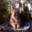

In [128]:
from PIL import Image

Image.fromarray(X_test[int(np.random.rand()*100)].astype('uint8'))

In [15]:
X_train.shape

(49000, 32, 32, 3)

In [16]:
X_train[0].reshape(-1).shape

(3072,)

In [0]:
def pipeline(X_train, y_train, X_val, y_val, X_test, y_test):
    X_train, X_val, X_test = X_train.reshape(X_train.shape[0], -1), X_val.reshape(X_val.shape[0], -1), X_test.reshape(X_test.shape[0], -1)
    # X_train, X_val, X_test = X_train / 255, X_val / 255, X_test / 255
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    X_train, X_val, X_test = (X_train - mean) / std, (X_val - mean) / std, (X_test - mean) / std 
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = pipeline(X_train, y_train, X_val, y_val, X_test, y_test)

In [0]:
model = KNearestNeighbor()
model = LinearSVM()
# model = Softmax()
# model = TwoLayerNet(3072, 1024, 10)

In [0]:
def train(model, X_train, y_train, **kwargs):

    def calculate_acc(predicts, y):
        acc = 0.0
        acc_tmp = 0.0
        loss = 0.0
        if predicts.ndim > 1:
            predicts = predicts.T

            for i, pred in enumerate(predicts):
                if np.argmax(pred) == y[i]:
                    acc_tmp += 1
        else:
            for i, pred in enumerate(predicts):
                if pred == y[i]:
                    acc_tmp += 1

        acc = acc_tmp / len(y)

        return acc

    run_data = []
    
    try:
        hist = model.train(
            X_train,
            y_train,
            X_val=kwargs['X_val'],
            y_val=kwargs['y_val'],
            learning_rate=kwargs['learning_rate'],
            reg=kwargs['reg'],
            num_iters=kwargs['num_iters'],
            batch_size=kwargs['batch_size'],
            verbose=kwargs['verbose']
            )
    except TypeError:
        hist = model.train(X_train, y_train)

    results = {}

    if hist is not None:
        if type(hist) == dict:
            results['train_acc'] = hist['train_acc_history'][-1]
            results['train_loss'] = hist['loss_history'][-1]

            results['vall_acc'] = hist['val_acc_history'][-1]
        else:
            results['train_acc'] = calculate_acc(model.predict(X_train), y_train)
            results['train_loss'] = hist[-1]

            results['vall_acc'] = calculate_acc(model.predict(X_val), y_val)
    else:
        results['train_acc'] = calculate_acc(model.predict(X_train), y_train)
        results['vall_acc'] = calculate_acc(model.predict(X_val), y_val)

    run_data.append(results)
    df = pd.DataFrame.from_dict(run_data, orient = 'columns')
    display(df)

    return model


In [119]:
n_samples = len(X_train)
# use this for KNN
# n_samples = 10000

model = train(
    model, 
    X_train[:n_samples], 
    y_train[:n_samples],
    X_val=X_val[:n_samples], 
    y_val=y_val[:n_samples],
    learning_rate=0.01,
    reg=1e-4,
    num_iters=600,
    batch_size=200,
    verbose=True
)

iteration 0 / 500: loss 8.983076
iteration 100 / 500: loss 4.991880
iteration 200 / 500: loss 4.235954
iteration 300 / 500: loss 4.790453
iteration 400 / 500: loss 4.694735


,train_acc,train_loss,vall_acc
0,0.392735,3.880905,0.397


# Evaluate model

In [0]:
def test_per_class(model, x, y):
    acc_per_class = {}
    predicts = model.predict(x)

    if predicts.ndim > 1:
        predicts = predicts.T
        predicts = np.argmax(predicts, axis=1)

    for cls in set(y):
        tmp = (y==cls)
        acc = (predicts[tmp]==y[tmp]).mean()
        acc_per_class[str(cls)] = acc
        print('class {0} accuracy {1:.3}%'.format(cls, acc*100))


In [121]:
test_per_class(model, X_val, y_val)

class 0 accuracy 33.3%
class 1 accuracy 44.5%
class 2 accuracy 21.5%
class 3 accuracy 33.0%
class 4 accuracy 32.1%
class 5 accuracy 20.4%
class 6 accuracy 50.0%
class 7 accuracy 39.3%
class 8 accuracy 69.9%
class 9 accuracy 41.9%


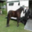